In [1]:
#Import data mainpulation modules
import pandas as pd
import numpy as np

#Import graphing libraries
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

#Import prophet function fb prophet
from fbprophet import Prophet

In [2]:
#Read data in
dat = pd.read_csv('../Data/bike_sharing_hourly.csv', parse_dates=['dteday'])

In [3]:
# Convert to datetime format
dat['dteday'] = pd.to_datetime(dat.dteday) + dat.hr.astype('timedelta64[h]')

In [4]:
#Make dteday dataframe's index
dat.set_index('dteday', drop=True, inplace=True)

In [5]:
#Create new column with a log of counts
dat['log_cnt'] = np.log(dat.cnt) + 1 #add constant to change 0's to 1's

In [6]:
#Convert weathersit into multiple dummy variables
wsit_dummies = pd.get_dummies(dat.weathersit)
wsit_dummies = wsit_dummies.iloc[:,0:3] #Drop one to avoid dummy variables trap

#Join dummies to original df
dat = dat.join(wsit_dummies)

In [7]:
#Check columns of data
dat.tail(2)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,log_cnt,1,2,3
dteday,,,,,,,,,,,,,,,,,,,,
2012-12-31 22:00:00,17378,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,5.110874,1,0,0
2012-12-31 23:00:00,17379,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49,4.891820,1,0,0


In [8]:
#Create dataframe of holidays
hol_df = pd.DataFrame({'holiday': 'hol', 'ds': dat[dat['holiday'] == 1].index})

## Visualizing Train and Test Splits

In [9]:
#Create train and test splits
train = dat['Jan 2011': 'November 2012']
test = dat['December 2012']

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


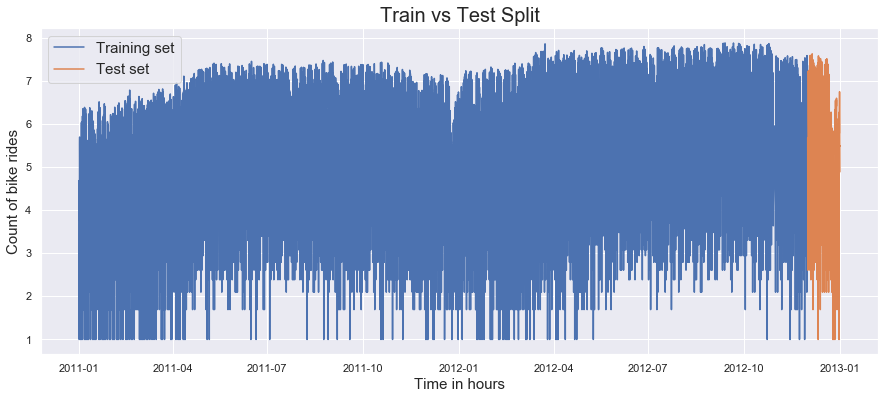

In [10]:
#Create plot
plt.figure(figsize=(15,6))
plt.xlabel('Time in hours', size=15)
plt.ylabel('Count of bike rides', size=15)
plt.title('Train vs Test Split', size=20)
plt.plot(train.index,train.loc[:,'log_cnt'], label='Training set')
plt.plot(test.index,test.loc[:,'log_cnt'], label='Test set')
plt.legend(prop={'size': 15})

#Save plot 
#plt.savefig('Train_test_split.pdf')

# Predicting with FB Prophet

In [11]:
#Create a dataframe to run prophet on
fb_df = pd.DataFrame()

fb_df['ds'] = train.index#dat.index
fb_df['y'] = train.log_cnt.values#np.log(dat.cnt.values)

In [12]:
#Number of future predictions to make
n_preds = test.shape[0]
n_preds

742

## Baseline Model

In [13]:
base_mod = Prophet(growth='linear')
base_mod.fit(fb_df)

#Make predictions
future_vals = base_mod.make_future_dataframe(freq='H', periods=n_preds)

/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [14]:
#Predict values
base_pred = base_mod.predict(future_vals)

In [15]:
#Functions to compute error metrics
def accuracy(pred, obs):
    
    '''
    Computes mean absolute percentage error
    Inputs: pred - Array of predicted/forecasted values
             obs - Array of actual values to be forecast
    Outputs: error_metrics - Dictionary with 3 values; RMSE, MAE, MAPE
    '''
    
    error_metrics = {}
    
    #Convert inputs to numpy arrays
    pred, obs = np.array(pred), np.array(obs)
    
    #Compute error metrics
    error_metrics['MAPE'] = np.mean(np.abs((obs - pred)/obs))*100
    error_metrics['RMSE'] = np.sqrt(np.mean((obs - pred)**2))
    error_metrics['MAE'] = np.mean(np.abs((obs - pred)))
    
    return error_metrics

In [16]:
#Compute error
base_train_set_error = accuracy(pred=base_pred.yhat[:dat.shape[0] - n_preds], 
                                obs=dat.log_cnt[:dat.shape[0] - n_preds])
print(base_train_set_error)

base_test_set_error = accuracy(pred=base_pred.yhat.tail(n_preds), 
                               obs=dat.log_cnt.tail(n_preds))
base_test_set_error

{'MAPE': 11.85341184996941, 'RMSE': 0.6614807794918931, 'MAE': 0.49189645049268393}


{'MAPE': 18.997888368490717,
 'RMSE': 1.0222070984621334,
 'MAE': 0.733641016678413}

## Back transforming predictions

In [17]:
def back_transform(og_pred_counts, pred_log_cnt, c=1):
    
    '''
    Reverse log transformation using bias adjustment to get mean of forecast distributions
    Inputs: pred_log_cnt - Pandas series of predicted log counts
                       c - Integer representing constant added to log values to avoid 0
    Outputs:          w0 - Pandas series of bias adjusted back transformed counts        
    '''
    
    w0 = np.exp(pred_log_cnt - c)
    
    #Compute constant using MM correction factor
    D = np.mean(og_pred_counts) / np.mean(w0)
    w = w0*D
    
    return w

In [18]:
#Compute train set accuracy
tr_pred_og_scale = back_transform(og_pred_counts=dat.cnt[:dat.shape[0] - n_preds], 
                               pred_log_cnt=base_pred.yhat[:dat.shape[0] - n_preds])
og_train_cnt = dat.cnt[:dat.shape[0] - n_preds]

accuracy(tr_pred_og_scale, og_train_cnt)

{'MAPE': 75.26757773879537,
 'RMSE': 105.40485078715332,
 'MAE': 69.78746519938412}

In [19]:
#Compute test set accuracy
pred_og_scale = back_transform(og_pred_counts=dat.cnt.tail(n_preds), 
                               pred_log_cnt=base_pred.yhat.tail(n_preds))
og_test_cnt = dat.cnt.tail(n_preds)

In [20]:
accuracy(pred_og_scale, og_test_cnt)

{'MAPE': 155.70023390685085,
 'RMSE': 127.83738042674571,
 'MAE': 85.88750135117105}

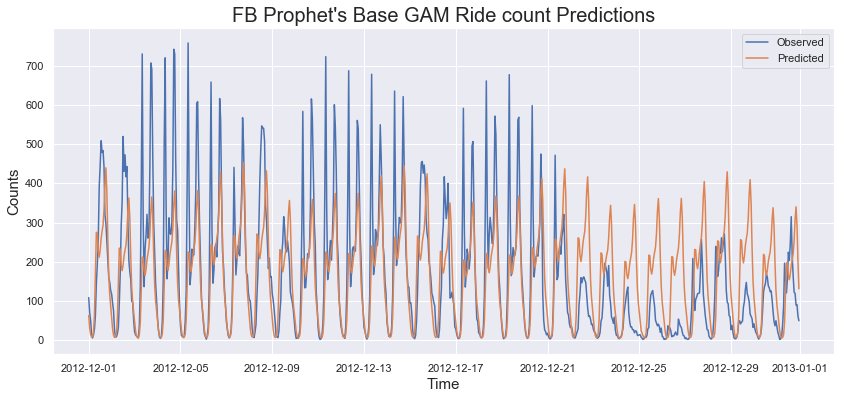

In [21]:
#Plot transformed predicted vs forecast values
plt.figure(figsize=(14,6))
plt.plot(og_test_cnt.index, og_test_cnt.values, label='Observed')
plt.plot(og_test_cnt.index, pred_og_scale, label='Predicted')
plt.ylabel('Counts', size=15)
plt.xlabel('Time', size=15)
plt.title('FB Prophet\'s Base GAM Ride count Predictions', size = 20)
plt.legend()
#plt.savefig('../Pictures/Model_comparisons/fbprop_base_og_preds.pdf')

## Tuned Model

### Step 1: Initialize model

To improve it's performance, I

1. Add a changepoint for each month

2. Use multiplicative seasonality? shouldn't matter as I employ a log transform

3. Use a large seasonal prior scale to make the system more sensitive to seasonality

4. Vary number of fourier terms for each type of seasonality modelled

The following modifications were adapted from https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [21]:
m = Prophet(n_changepoints=(12*2*1), 
           seasonality_mode='additive', 
           seasonality_prior_scale=35, 
           daily_seasonality=False, 
           weekly_seasonality=False,
           yearly_seasonality=False 
           ).add_seasonality(
    name='daily', 
    period=1,
    fourier_order=15).add_seasonality(
    name='weekly', 
    period=7,
    fourier_order=20
).add_seasonality(
    name='yearly', 
    period=365.25,
    fourier_order=20
).add_country_holidays(country_name='US') #Add holidays using built in function

#.add_seasonality(name='Monthly', period = (365.25/12), fourier_order=55)
#.add_seasonality(name='quarterly', period=365.25/4,fourier_order=5)

In [22]:
#Fit prophet
# m = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=True, 
#             seasonality_prior_scale=0.1)

### Step 2: Predict using fitted model

In [23]:
#Fit model
m.fit(fb_df)

/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
#Create future predictions using fitted model
future = m.make_future_dataframe(periods=n_preds, freq='H', include_history=True)
forecast = m.predict(future)

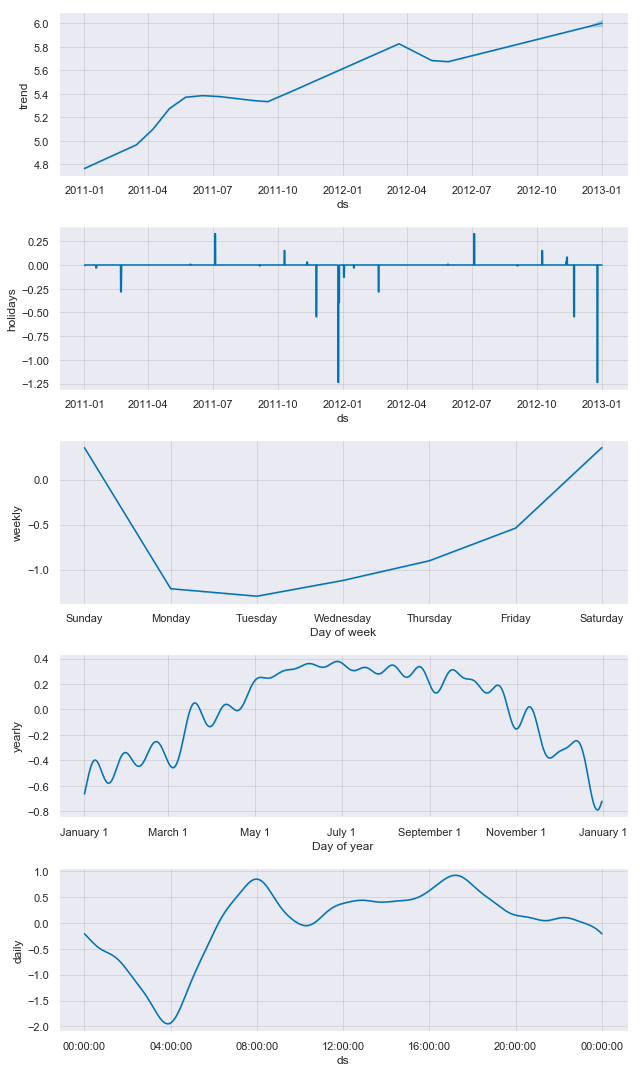

In [25]:
fig2=m.plot_components(forecast)

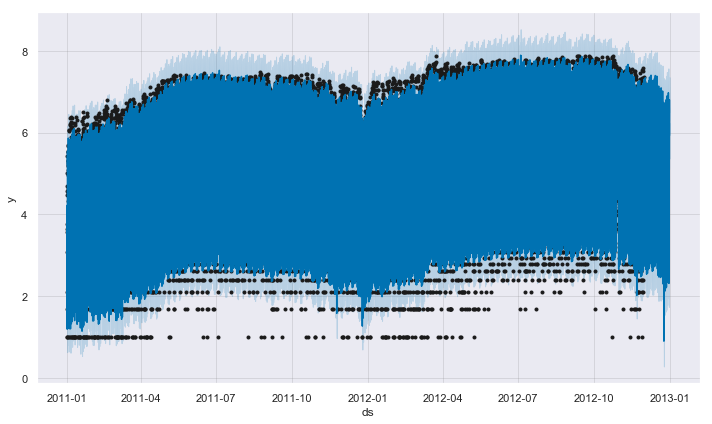

In [26]:
forecast_plot=m.plot(forecast)

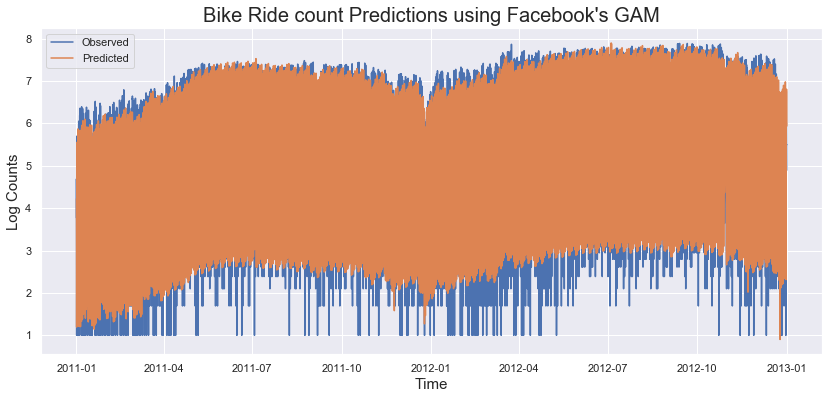

In [27]:
#Plot predicted vs forecast values
plt.figure(figsize=(14,6))
plt.plot(dat.index, dat.loc[:,'log_cnt'], label='Observed')
plt.plot(dat.index, forecast.loc[:,'yhat'], label='Predicted')
plt.ylabel('Log Counts', size=15)
plt.xlabel('Time', size=15)
plt.title('Bike Ride count Predictions using Facebook\'s GAM', size = 20)
plt.legend()
#plt.savefig('no_addreg_fbprop.pdf')

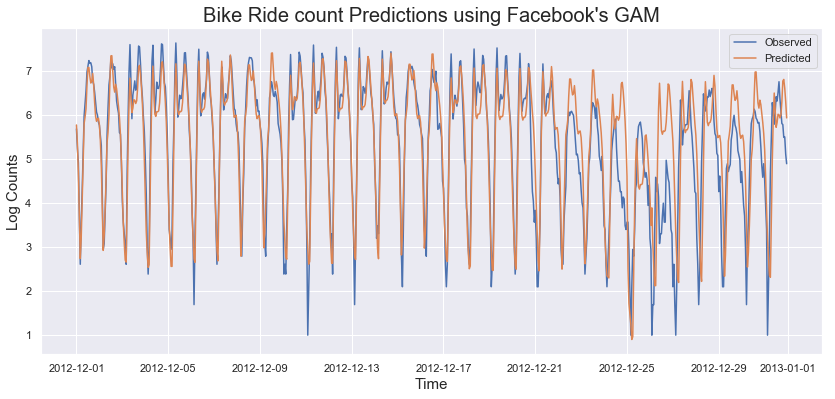

In [28]:
#Visualize test set predictions only
n_preds=test.shape[0]

plt.figure(figsize=(14,6))
plt.plot(test.index, test.loc[:,'log_cnt'], label='Observed')
plt.plot(test.index, forecast.yhat.tail(n=n_preds), label='Predicted')
plt.ylabel('Log Counts', size=15)
plt.xlabel('Time', size=15)
plt.title('Bike Ride count Predictions using Facebook\'s GAM', size = 20)
plt.legend()
#plt.savefig('testset_no_addreg_fbprop.pdf')

In [29]:
#Compute errors
train_set_error = accuracy(pred=forecast.yhat[:dat.shape[0] - n_preds], 
                           obs=dat.log_cnt[:dat.shape[0] - n_preds])
print(train_set_error)
#Test set
test_set_error = accuracy(pred=forecast.yhat.tail(n=n_preds), 
                          obs=dat.log_cnt.tail(n=n_preds))
test_set_error

{'MAPE': 7.917288926185958, 'RMSE': 0.45432011038425507, 'MAE': 0.32034573834587454}


{'MAPE': 13.396841522808622,
 'RMSE': 0.765687106505799,
 'MAE': 0.5218580335698408}

In [32]:
#Compute test set accuracy on back transformed scale
pred_og_scale = back_transform(og_pred_counts=dat.cnt.tail(n_preds), 
                               pred_log_cnt=forecast.yhat.tail(n_preds))
og_test_cnt = dat.cnt.tail(n_preds)

In [33]:
accuracy(pred_og_scale, og_test_cnt)

{'MAPE': 96.60678959125589,
 'RMSE': 84.84208649168094,
 'MAE': 56.734492231447035}

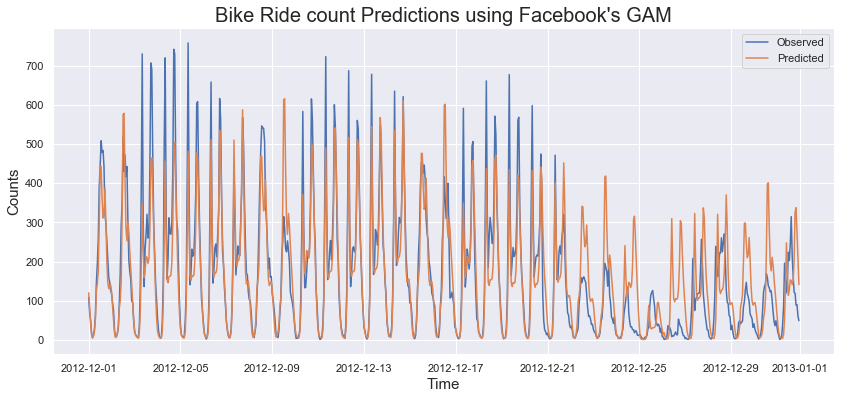

In [34]:
#Plot transformed predicted vs forecast values
plt.figure(figsize=(14,6))
plt.plot(og_test_cnt.index, og_test_cnt.values, label='Observed')
plt.plot(og_test_cnt.index, pred_og_scale, label='Predicted')
plt.ylabel('Counts', size=15)
plt.xlabel('Time', size=15)
plt.title('Bike Ride count Predictions using Facebook\'s GAM', size = 20)
plt.legend()
#plt.savefig('../Pictures/Model_comparisons/incorrectly_tuned_fbprop.pdf')